In [1]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import swellEx_env
from normalMode import Chinook
from beamformers import bartlet

# Basic synthetic matched field with few external functions

In [2]:
# Experimental data
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
fs = 1500
tStart = 1000
snapLength = 2
snapStep = 1
sD = 54

In [3]:
frequencies = [49, 64, 79, 94, 112, 130, 148, 166, 201, 235, 283, 338, 388]

rSource = 6e3
zSource = 44

enviornment = swellEx_env.loadEnviornment(ctdNumber = 6)
sensorPosition = swellEx_env.loadArray()

# Match field boundries
zMax = enviornment.getProfile(0.).getZatInterface()[1]
rMax = 1e4  # m
numR = 200
numZ = 100

# Solver Parameters
decimation = 10
fB_width = 300

In [4]:
zPlot = np.r_[0:zMax:numZ * 1j]
rPlot = np.r_[10:rMax:numR * 1j]
R_nm, Z = np.meshgrid(rPlot, zPlot)

In [5]:
fOfInterest = frequencies

# Synthetic data set
K = []
lookVectors = []
for f in fOfInterest:
    nm_model = Chinook(f, enviornment)
    nm_model.calculateModes_eig(fB_width, decimation)
    p = nm_model.calculatePressure(zSource, sensorPosition, rSource)
    K.append(np.outer(p, np.array(p).conj()))
    lookVectors.append([nm_model.calculatePressure(d, zPlot, rPlot) for d in sensorPosition])
K = pd.Series(K, index = fOfInterest)

In [6]:
W = []
for lv in lookVectors:
    lv = np.dstack(lv)
    lv = lv / np.linalg.norm(lv, axis = 2)[:,:,None]
    lv = np.nan_to_num(lv)
    shape_3d = lv.shape
    W.append(np.reshape(lv, (shape_3d[0] * shape_3d[1], shape_3d[2])))

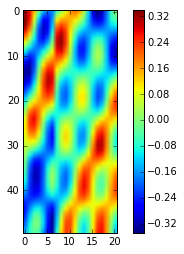

In [7]:
_ = plt.imshow(np.real(np.array(W[1]))[1250:1300,:])
_ = plt.colorbar()

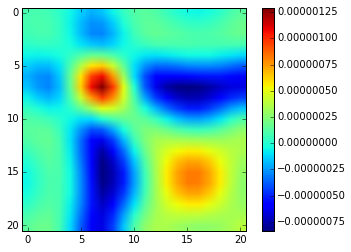

In [8]:
_ = plt.imshow(np.real(K.iloc[1]))
_ = plt.colorbar()

In [9]:
def bart_DB(K, W):
    B_bart = bartlet(K, W)
    B_bart = np.reshape(B_bart, (numR, numZ))
    B_bart = 10 * np.log10(np.abs(B_bart) + np.spacing(1))
    B_bart = B_bart - np.max(B_bart)
    return B_bart

In [10]:
B_bart = [bart_DB(k, w) for k, w in zip(K, W)]

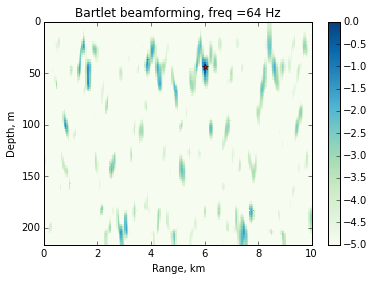

In [11]:
plotI = 1
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_bart[plotI]).T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Bartlet beamforming, freq =' + str(fOfInterest[plotI]) + ' Hz')
_ = plt.plot(rSource / 1e3, zSource, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

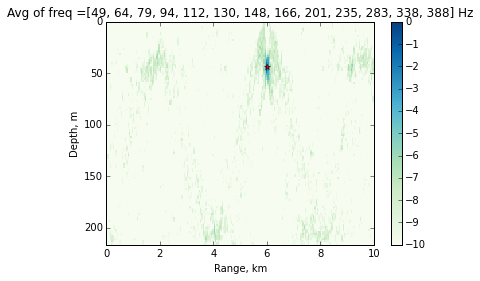

In [12]:
avgBart = np.sum(np.array(B_bart), axis = 0) / len(B_bart)
_ = plt.pcolormesh(R_nm / 1e3, Z, avgBart.T, cmap = plt.cm.GnBu)
_ = plt.clim(-10, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Avg of freq =' + str(fOfInterest) +' Hz')
_ = plt.plot(rSource / 1e3, zSource, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')